<h1 style="color: #002B5B;">Main Heading 1</h1>
<h3 style="color: #0F52BA;">Subheading 1</h3> <!-- Sapphire Blue -->
<h3 style="color: #2F70C0;">Subheading 2</h3> <!-- Muted Blue -->
<h3 style="color: #5A9BD5;">Subheading 3</h3> <!-- Soft Professional Blue -->

<h1 style="color: #002B5B;">✬ Import and Install Dependencies</h1>

In [72]:
import cv2
import math as math
import os
import mediapipe as mp
import re 
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Lambda, RepeatVector,  TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import load_model
from collections import deque
import time


<h1 style="color: #002B5B;">1. Dataset Extraction & Preprocessing</h1>

<h3 style="color: #0F52BA;">1.1 Extract Body Landmarks from Videos</h3>

<h4 style="color: #2F70C0;">1.1.1 Class and Functions to Collect The Exercise Features</h4>

This module uses MediaPipe to extract body landmarks from video frames, calculates key features (knee angle, heel-to-hip distance), determines the active side and leg state, counts exercise repetitions, evaluates posture, and provides detected landmarks visualization functions.

In [13]:
class ChairExerciseFeatures:
    def __init__(self, cap=None):
        """
        Initializes the MediaPipe pose detector, threshold values, repetition counters,
        and state variables needed for pose tracking and posture analysis.
        """
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils

        self.HEEL_TO_HIP_THRESHOLD = 0.2
        self.NECK_ANGLE_THRESHOLD = 40
        self.TORSO_ANGLE_THRESHOLD = 10
        self.LEG_RAISE_Y_DIFF = 0.1

        self.rep_count = {"Left": 0, "Right": 0}
        self.rep_started = {"Left": False, "Right": False}
        self.baseline_distance = {"Left": None, "Right": None}
        self.baseline_knee_angle = {"Left": None, "Right": None}
        self.active_side = None
        self.neck_inclination = None
        self.torso_inclination = None

    def get_landmarks(self, frame):
        """
        Processes a video frame using MediaPipe Pose to detect landmarks.

        Args:
            frame (ndarray): The video frame in BGR format.

        Returns:
            list or None: List of pose landmarks if detected, else None.
        """
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.pose.process(rgb_frame)
        return results.pose_landmarks.landmark if results.pose_landmarks else None

    def get_joint(self, landmarks, joint_name):
        """
        Retrieves a specific joint's landmark from the landmark list.

        Args:
            landmarks (list): List of pose landmarks.
            joint_name (str): Name of the joint.

        Returns:
            Landmark: The corresponding landmark object.
        """
        return landmarks[self.mp_pose.PoseLandmark[joint_name].value]

    def check_body_visibility(self, landmarks):
        """
        Determines which parts of the body are visible in the frame.

        Args:
            landmarks (list): MediaPipe pose landmarks.

        Returns:
            str: "full_body", "left_side", "right_side", or "not_visible".
        """
        full_body = [0, 7, 8, 11, 12, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
        left_side = [7, 11, 23, 25, 27, 29, 31]
        right_side = [8, 12, 24, 26, 28, 30, 32]

        def are_visible(required):
            return all(
                landmarks[i].visibility >= 0.5 and 0 <= landmarks[i].x <= 1 and 0 <= landmarks[i].y <= 1
                for i in required
            )

        if are_visible(full_body):
            return "full_body"
        elif are_visible(left_side):
            return "left_side"
        elif are_visible(right_side):
            return "right_side"
        return "not_visible"

    def calculate_distance(self, lm1, lm2):
        """
        Calculates the Euclidean distance between two landmarks.

        Args:
            lm1 (Landmark): First point.
            lm2 (Landmark): Second point.

        Returns:
            float: Distance between the two points.
        """
        return math.sqrt((lm1.x - lm2.x)**2 + (lm1.y - lm2.y)**2)

    def update_rep_count(self, landmarks):
        """
        Counts a rep only once when a leg transitions from rest to extended.
        Waits for legs to return to rest (aligned) before allowing another count.
        """
        if self.are_feet_aligned(landmarks):
            # Legs are back at rest position, reset state to allow next rep
            for leg in ["Left", "Right"]:
                self.rep_started[leg] = False
            return
    
        raised_leg = self.is_leg_raised(landmarks)
        if not raised_leg:
            return  # Can't determine which leg is raised
    
        # Set active side dynamically
        self.active_side = "left_side" if raised_leg == "Left" else "right_side"
    
        if not self.rep_started[raised_leg]:
            # Count rep on transition to extended state
            self.rep_count[raised_leg] += 1
            self.rep_started[raised_leg] = True



    def get_leg_distance(self, landmarks, leg):
        """
        Computes the current heel-to-hip distance for a specified leg.

        Args:
            landmarks (list): MediaPipe pose landmarks.
            leg (str): "Left" or "Right".

        Returns:
            float: Distance between heel and hip.
        """
        heel = self.get_joint(landmarks, f"{leg.upper()}_HEEL")
        hip = self.get_joint(landmarks, f"{leg.upper()}_HIP")
        return self.calculate_distance(hip, heel)

    def get_leg_state(self, distance):
        """
        Returns the state of the leg (Extended or Rest).

        Args:
            distance (float): Distance between heel and hip.

        Returns:
            str: "Extended" if leg is raised, otherwise "Rest".
        """
        return "Extended" if distance < self.HEEL_TO_HIP_THRESHOLD else "Rest"

    def find_posture_angle(self, x1, y1, x2, y2):
        """
        Calculates the vertical inclination angle between two points.

        Args:
            x1, y1, x2, y2 (float): Coordinates of the two points.

        Returns:
            float: Angle in degrees from the vertical.
        """
        theta = math.acos((y2 - y1) * (-y1) / (math.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
        degree = int((180 / math.pi) * theta)
        return degree

    def is_sitting_correctly(self, landmarks, side):
        """
        Determines if the posture is correct based on neck and torso angles.

        Args:
            landmarks (list): Pose landmarks.
            side (str): Side being evaluated ("left_side" or "right_side").

        Returns:
            str: "Good Posture" or "Bad Posture".
        """
        if not landmarks:
            return "Bad Posture"
        if side in ["right_side", "full_body"]:
            ear = self.get_joint(landmarks, "RIGHT_EAR")
            shoulder = self.get_joint(landmarks, "RIGHT_SHOULDER")
            hip = self.get_joint(landmarks, "RIGHT_HIP")
        else:
            ear = self.get_joint(landmarks, "LEFT_EAR")
            shoulder = self.get_joint(landmarks, "LEFT_SHOULDER")
            hip = self.get_joint(landmarks, "LEFT_HIP")
        neck_angle = self.find_posture_angle(shoulder.x, shoulder.y, ear.x, ear.y)
        torso_angle = self.find_posture_angle(hip.x, hip.y, shoulder.x, shoulder.y)
        return "Good Posture" if neck_angle < self.NECK_ANGLE_THRESHOLD and torso_angle < self.TORSO_ANGLE_THRESHOLD else "Bad Posture"

    def is_leg_raised(self, landmarks):
        """
        Detects which leg is currently raised based on y-position.

        Args:
            landmarks (list): Pose landmarks.

        Returns:
            str or None: "Left", "Right", or None.
        """
        left_foot_y = self.get_joint(landmarks, "LEFT_FOOT_INDEX").y
        right_foot_y = self.get_joint(landmarks, "RIGHT_FOOT_INDEX").y
        if left_foot_y < right_foot_y - self.LEG_RAISE_Y_DIFF:
            return "Left"
        elif right_foot_y < left_foot_y - self.LEG_RAISE_Y_DIFF:
            return "Right"
        return None

    def calculate_knee_angle(self, hip, knee, ankle):
        """
        Calculates the angle at the knee joint using 3 landmarks.

        Args:
            hip (Landmark): Hip joint.
            knee (Landmark): Knee joint.
            ankle (Landmark): Ankle joint.

        Returns:
            float or None: Angle at the knee in degrees.
        """
        if not all([hip, knee, ankle]):
            return None
        thigh = [knee.x - hip.x, knee.y - hip.y]
        shin = [knee.x - ankle.x, knee.y - ankle.y]
        dot = thigh[0]*shin[0] + thigh[1]*shin[1]
        mag_thigh = math.hypot(*thigh)
        mag_shin = math.hypot(*shin)
        if mag_thigh == 0 or mag_shin == 0:
            return None
        cos_angle = max(min(dot / (mag_thigh * mag_shin), 1.0), -1.0)
        return math.degrees(math.acos(cos_angle))

    def check_leg_angle(self, landmarks, leg):
        """
        Calculate the Knee angle when it is Extended and when is it in Rest.

        Args:
            landmarks (list): MediaPipe pose landmarks.
            leg (str): "Left" or "Right" indicating the active leg.

        Returns:
            float or None: The calculated knee angle.
        """
        if not landmarks or not leg:
            return None
        hip = self.get_joint(landmarks, f"{leg.upper()}_HIP")
        knee = self.get_joint(landmarks, f"{leg.upper()}_KNEE")
        ankle = self.get_joint(landmarks, f"{leg.upper()}_ANKLE")
        return self.calculate_knee_angle(hip, knee, ankle)

    def are_feet_aligned(self, landmarks, threshold=0.05):
        """
        Checks if both feet are aligned vertically within a threshold.

        Args:
            landmarks (list): MediaPipe pose landmarks.
            threshold (float): Maximum allowed Y difference between feet.

        Returns:
            bool: True if feet are aligned within the threshold.
        """
        left_y = self.get_joint(landmarks, "LEFT_FOOT_INDEX").y
        right_y = self.get_joint(landmarks, "RIGHT_FOOT_INDEX").y
        return abs(left_y - right_y) < threshold

    def draw_landmarks(self, frame, results, raised_leg):
        """
        Draws the pose landmarks and highlights the active knee joint.

        Args:
            frame (ndarray): The video frame.
            results: MediaPipe pose detection result.
            raised_leg (str or None): "Left" or "Right" leg being raised.
        """
        if results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS,
                self.mp_drawing.DrawingSpec(color=(200, 100, 0), thickness=2, circle_radius=2),
                self.mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2)
            )
            if raised_leg:
                knee_idx = self.mp_pose.PoseLandmark[f"{raised_leg.upper()}_KNEE"].value
                knee = results.pose_landmarks.landmark[knee_idx]
                x = int(knee.x * frame.shape[1])
                y = int(knee.y * frame.shape[0])
                cv2.circle(frame, (x, y), 12, (0, 0, 255), 3)
                cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)

    def detection_quality(self, landmarks):
        """
        Evaluates the visibility quality of the active leg's joints.

        Returns:
            float: Average visibility score, or 0.0 if data is invalid.
        """
        joints = []
        try:
            if self.active_side == "left_side":
                joints = ["LEFT_HIP", "LEFT_KNEE", "LEFT_ANKLE"]
            elif self.active_side == "full_body" or "right_side":
                joints = ["RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE"]
            visibilities = [self.get_joint(landmarks, j).visibility for j in joints]
            return sum(visibilities) / len(visibilities)
        except:
            return 0.0

def overlay_avatar(frame, avatar_img, x_offset=0, y_offset=0):
    """
    Overlays an avatar image on the video frame at the given offset.

    Args:
        frame (ndarray): Background video frame.
        avatar_img (ndarray): Avatar image to overlay.
        x_offset (int): Horizontal position.
        y_offset (int): Vertical position.

    Returns:
        ndarray: Frame with avatar image overlay.
    """
    if avatar_img is None:
        return frame
    h, w, _ = frame.shape
    ah, aw, _ = avatar_img.shape
    if y_offset + ah > h:
        ah = h - y_offset
    if x_offset + aw > w:
        aw = w - x_offset
    roi = frame[y_offset:y_offset + ah, x_offset:x_offset + aw]
    roi[:] = avatar_img[0:ah, 0:aw]
    return frame


<h4 style="color: #2F70C0;">1.1.2 Process The Videos to Extract The Exercise Features </h4>

<p>
  The output dictionary for each frame contains the following keys:<br/>
  &nbsp;&nbsp;– <code>frame_index</code>: Sequential frame number.<br/>
  &nbsp;&nbsp;– <code>timestamp</code>: Time in seconds from the start of the video.<br/>
  &nbsp;&nbsp;– <code>body_visibility</code>: Which side is visible (<code>"full_body"</code>, <code>"left_side"</code>, <code>"right_side"</code>, or <code>"not_visible"</code>).<br/>
  &nbsp;&nbsp;– <code>sitting_posture</code>: Evaluation of the posture (<code>"Good Posture"</code> or <code>"Bad Posture"</code>).<br/>
  &nbsp;&nbsp;– <code>leg</code>: Active leg (<code>"Left"</code> or <code>"Right"</code>).<br/>
  &nbsp;&nbsp;– <code>leg_status</code>: Leg state determined by heel‐to‐hip distance (<code>"Extended"</code> or <code>"Rest"</code>).<br/>
  &nbsp;&nbsp;– <code>knee_angle</code>: Calculated knee angle in degrees.<br/>
  &nbsp;&nbsp;– <code>distance</code>: Normalized heel‐to‐hip distance.<br/>
  &nbsp;&nbsp;– <code>rep_count</code>: Number of repetitions recorded for the active side.<br/>
  &nbsp;&nbsp;– <code>neck_inclination</code>: Neck inclination angle in degrees.<br/>
  &nbsp;&nbsp;– <code>torso_inclination</code>: Torso inclination angle in degrees.<br/>
  &nbsp;&nbsp;– <code>exercise_type</code>: The type of exercise (<code>"Chair Exercise"</code>).<br/>
  &nbsp;&nbsp;– <code>video_path</code>: Video file name.<br/>
</p>


In [14]:
# -----------------------------------------------------------------------------
# Process Chair-Exercise Videos to Extract Frame-Level Features
# -----------------------------------------------------------------------------
def process_chair_video(video_path, output_file=None):
    """
    Read a chair-exercise video, extract frame‑level features via ChairExerciseFeatures,
    and return a pandas DataFrame of results.
    """
    # -------------------------------------------------------------------------
    # 1. Initialize Detector and Video Capture
    # -------------------------------------------------------------------------
    checker = ChairExerciseFeatures()         # our custom pose/feature class
    cap     = cv2.VideoCapture(video_path)    # open the video file
    fps     = cap.get(cv2.CAP_PROP_FPS) or 30 # frames per second (fallback to 30)
    frame_idx      = 0                        # sequential frame counter
    exercise_type  = "Chair Exercise"         # constant label
    base_name      = os.path.basename(video_path)
    frame_data     = []                       # collect each frame’s dict

    # -------------------------------------------------------------------------
    # 2. Frame Processing Loop
    # -------------------------------------------------------------------------
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # end of video

        # 2.a. Compute timestamp
        timestamp = frame_idx / fps

        # 2.b. Extract landmarks
        landmarks = checker.get_landmarks(frame)

        # 2.c. Default values in case of no detection
        visibility, posture = "not_visible", "Bad Posture"
        leg, state = None, None
        knee_ang, dist = None, None
        neck_ang, torso_ang = None, None

        # ---------------------------------------------------------------------
        # 3. If Landmarks Found → Compute All Features
        # ---------------------------------------------------------------------
        if landmarks:
            # 3.a. Body visibility
            visibility = checker.check_body_visibility(landmarks)

            # 3.b. Update rep count
            checker.update_rep_count(landmarks)

            # 3.c. Active leg side
            leg = {"left_side": "Left", "right_side": "Right"}.get(checker.active_side)

            # 3.d. Heel‑to‑hip distance & leg state
            if leg:
                dist  = checker.get_leg_distance(landmarks, leg)
                state = checker.get_leg_state(dist)

            # 3.e. Knee angle
            knee_ang = checker.check_leg_angle(landmarks, leg)

            # 3.f. Overall posture correctness
            posture = checker.is_sitting_correctly(landmarks, checker.active_side)

            # 3.g. Neck & torso inclination
            if checker.active_side in ("left_side", "full_body"):
                ear, shoulder, hip = (
                    checker.get_joint(landmarks, j) for j in
                    ("LEFT_EAR", "LEFT_SHOULDER", "LEFT_HIP")
                )
            else:
                ear, shoulder, hip = (
                    checker.get_joint(landmarks, j) for j in
                    ("RIGHT_EAR", "RIGHT_SHOULDER", "RIGHT_HIP")
                )
            neck_ang  = checker.find_posture_angle(shoulder.x, shoulder.y, ear.x,   ear.y)
            torso_ang = checker.find_posture_angle(hip.x,      hip.y,      shoulder.x, shoulder.y)

        # ---------------------------------------------------------------------
        # 4. Build Feature Dictionary for This Frame
        # ---------------------------------------------------------------------
        row = {
            "frame_index":       frame_idx,
            "timestamp":         timestamp,
            "body_visibility":   visibility,
            "sitting_posture":   posture,
            "leg":               leg or "N/A",
            "leg_status":        state or "N/A",
            "knee_angle":        knee_ang,
            "distance":          dist,
            "rep_count":         checker.rep_count.get(leg, 0) if leg else 0,
            "neck_inclination":  neck_ang,
            "torso_inclination": torso_ang,
            "exercise_type":     exercise_type,
            "video_path":        base_name,
        }
        frame_data.append(row)
        frame_idx += 1

    # -------------------------------------------------------------------------
    # 5. Release Video and Assemble DataFrame
    # -------------------------------------------------------------------------
    cap.release()
    df = pd.DataFrame(frame_data)

    # -------------------------------------------------------------------------
    # 6. Optional: Save to CSV
    # -------------------------------------------------------------------------
    if output_file:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)

    return df

<h4 style="color: #2F70C0;">1.1.3 Extract The Data </h4>

In [15]:

if __name__ == "__main__":
    # -------------------------------------------------------------------------
    # A. Locate All Chair-Exercise Videos
    # -------------------------------------------------------------------------
    data_folder = "Chair Exercise/data"
    videos = [
        os.path.join(data_folder, f)
        for f in os.listdir(data_folder)
        if f.lower().endswith((".avi", ".mp4"))
    ]

    # -------------------------------------------------------------------------
    # B. Process Each Video and Collect Results
    # -------------------------------------------------------------------------
    all_results = []
    for vid in videos:
        print(f"→ Processing: {vid}")
        df_video = process_chair_video(vid)
        all_results.append(df_video)

    # -------------------------------------------------------------------------
    # C. Concatenate and Save Combined Data
    # -------------------------------------------------------------------------
    df_all      = pd.concat(all_results, ignore_index=True)
    output_csv  = "output/chair_exercise_data.csv"
    output_pkl  = "output/chair_exercise_data.pkl"
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df_all.to_csv(output_csv, index=False)
    df_all.to_pickle(output_pkl)

    print(f"✔ Combined data saved to:\n  • {output_csv}\n  • {output_pkl}")

→ Processing: Chair Exercise/data/Ac3_Eg7_R4_C.avi


I0000 00:00:1745203207.147745   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745203207.370936   87986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203207.631693   87984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203207.707963   87983 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


→ Processing: Chair Exercise/data/Ac4_Eg7_R4_C.avi


I0000 00:00:1745203264.452293   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203264.636045   89884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203264.783295   89887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R2_C.avi


I0000 00:00:1745203322.602545   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203322.803245   91458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203322.969433   91455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R2_C.avi


I0000 00:00:1745203381.445937   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203381.735403   93669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203381.908427   93673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac3_Eg7_R6_C.avi


I0000 00:00:1745203462.419709   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203462.715735   96577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203462.882638   96582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac4_Eg7_R6_C.avi


I0000 00:00:1745203531.778289   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203532.004545   99267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203532.173983   99269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac4_Eg7_R2_C.avi


I0000 00:00:1745203632.745491   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203633.094922  102719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203633.378187  102719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac3_Eg7_R2_C.avi


I0000 00:00:1745203711.974728   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203712.168295  105347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203712.327019  105347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R4_C.avi


I0000 00:00:1745203799.241832   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203799.514338  108765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203799.711459  108767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R4_C.avi


I0000 00:00:1745203874.280252   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203874.570353  111277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203874.755577  111277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R6_C.avi


I0000 00:00:1745203959.003949   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745203959.242448  113850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745203959.412270  113854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R6_C.avi


I0000 00:00:1745204029.189143   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204029.560037  115915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204029.939070  115915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R1_C.avi


I0000 00:00:1745204107.020704   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204107.313905  118331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204107.513887  118337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R1_C.avi


I0000 00:00:1745204181.041426   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204181.254855  121054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204181.423020  121054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac4_Eg7_R5_C.avi


I0000 00:00:1745204256.501938   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204256.739081  124039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204256.943968  124039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac3_Eg7_R5_C.avi


I0000 00:00:1745204327.393801   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204327.597585  126555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204327.821583  126561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R3_C.avi


I0000 00:00:1745204398.848721   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204399.045684  129297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204399.222269  129297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R3_C.avi


I0000 00:00:1745204461.685088   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204461.940150  131475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204462.113191  131479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac3_Eg7_R1_C.avi


I0000 00:00:1745204534.574992   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204534.773699  133966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204534.935451  133967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac4_Eg7_R1_C.avi


I0000 00:00:1745204583.831096   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204584.024868  136069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204584.216332  136071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac3_Eg7_R3_C.avi


I0000 00:00:1745204642.898174   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204643.085245  137834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204643.265517  137838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac4_Eg7_R3_C.avi


I0000 00:00:1745204698.858110   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204699.055813  139477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204699.244389  139480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac2_Eg7_R5_C.avi


I0000 00:00:1745204763.258114   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204763.453529  141427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204763.620637  141427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac5_Eg7_R5_C.avi


I0000 00:00:1745204818.565456   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204818.774733  143116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204818.963893  143116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R1_C.avi


I0000 00:00:1745204881.956491   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204882.148489  145245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204882.329994  145245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R3_C.avi


I0000 00:00:1745204947.986386   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745204948.190136  147329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745204948.376396  147327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R5_C.avi


I0000 00:00:1745205008.047432   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745205008.223403  149726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745205008.363708  149726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R2_C.avi


I0000 00:00:1745205062.075193   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745205062.248482  151384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745205062.378497  151388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R4_C.avi


I0000 00:00:1745205120.554464   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745205120.754158  153360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745205120.898486  153360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


→ Processing: Chair Exercise/data/Ac1_Eg7_R6_C.avi


I0000 00:00:1745205171.900362   33126 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1745205172.084049  154847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745205172.243357  154847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✔ Combined data saved to:
  • output/chair_exercise_data.csv
  • output/chair_exercise_data.pkl


<h3 style="color: #0F52BA;">1.2 Dataset Information (Before Preprocessing)</h3>

<h4 style="color: #2F70C0;">1.2.1 Dataset Details</h4>

In [16]:
# -----------------------------------------------------------------------------
# 1.2.1 Dataset Details (Before Preprocessing)
# -----------------------------------------------------------------------------
import pandas as pd

# Load the combined raw data.
# NOTE: Adjust the path if you saved under a different name.
df = pd.read_pickle("output/chair_exercise_data.pkl")

# Display high‑level info about the dataset.
print("=" * 50)
print("Dataset Details (Before Preprocessing):")
print(f"• Number of videos: {df['video_path'].nunique()} videos")   # unique clips
print(f"• Total frames: {len(df):,} frames")                       # overall frame count

# Sum the maximum rep_count per video to get total reps.
total_reps = df.groupby("video_path")["rep_count"].max().sum()
print(f"• Total repetitions: {int(total_reps)} reps")

# Show time span and approximate average FPS.
start, end = df["timestamp"].min(), df["timestamp"].max()
print(f"• Time range: {start:.1f}s to {end:.1f}s")
print(f"• Approximate FPS: {len(df) / end:.1f}")

# Show structure summary.
print("\nDataFrame Info:")
df.info()

Dataset Details (Before Preprocessing):
• Number of videos: 30 videos
• Total frames: 21,522 frames
• Total repetitions: 162 reps
• Time range: 0.0s to 28.1s
• Approximate FPS: 765.0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21522 entries, 0 to 21521
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frame_index        21522 non-null  int64  
 1   timestamp          21522 non-null  float64
 2   body_visibility    21522 non-null  object 
 3   sitting_posture    21522 non-null  object 
 4   leg                21522 non-null  object 
 5   leg_status         21522 non-null  object 
 6   knee_angle         18738 non-null  float64
 7   distance           18738 non-null  float64
 8   rep_count          21522 non-null  int64  
 9   neck_inclination   21522 non-null  int64  
 10  torso_inclination  21522 non-null  int64  
 11  exercise_type      21522 non-null  object 
 12  video_path    

<h4 style="color: #2F70C0;">1.2.2 Dataset Columns</h4>

In [17]:
# -----------------------------------------------------------------------------
# 1.2.2 Dataset Columns
# -----------------------------------------------------------------------------
# Define human‑readable descriptions for each column in df.
columns_details = {
    "frame_index":       "Frame sequence number (0-based index)",
    "timestamp":         "Elapsed time in seconds from video start",
    "body_visibility":   "Which side is visible [left_side, right_side, not_visible]",
    "sitting_posture":   "Posture evaluation [Good Posture, Bad Posture]",
    "leg":               "Active leg [Left, Right, or N/A]",
    "leg_status":        "Leg state [Pulled or Rest]",
    "knee_angle":        "Knee joint angle in degrees",
    "distance":          "Normalized heel‑to‑hip distance",
    "rep_count":         "Cumulative repetitions counted",
    "neck_inclination":  "Neck inclination angle in degrees",
    "torso_inclination": "Torso inclination angle in degrees",
    "exercise_type":     "Type of exercise [Chair Exercise]",
    "video_path":        "Video file name",
}

# Print each column name and its description.
print("=" * 50)
print("Dataset Columns:")
for col, desc in columns_details.items():
    print(f"- {col + ':':<20} {desc}")

# Show the first few rows to confirm column names.
print("\nDataFrame Head:")
print(df.head(5))


Dataset Columns:
- frame_index:         Frame sequence number (0-based index)
- timestamp:           Elapsed time in seconds from video start
- body_visibility:     Which side is visible [left_side, right_side, not_visible]
- sitting_posture:     Posture evaluation [Good Posture, Bad Posture]
- leg:                 Active leg [Left, Right, or N/A]
- leg_status:          Leg state [Pulled or Rest]
- knee_angle:          Knee joint angle in degrees
- distance:            Normalized heel‑to‑hip distance
- rep_count:           Cumulative repetitions counted
- neck_inclination:    Neck inclination angle in degrees
- torso_inclination:   Torso inclination angle in degrees
- exercise_type:       Type of exercise [Chair Exercise]
- video_path:          Video file name

DataFrame Head:
   frame_index  timestamp body_visibility sitting_posture  leg leg_status  \
0            0   0.000000       full_body    Good Posture  N/A        N/A   
1            1   0.033333       full_body    Good Posture 

<h4 style="color: #2F70C0;">1.2.3 Dataset Visualization (Before Preprocessing)</h4>

<h4 style="color:rgb(29, 75, 130);">Body Visibility Distribution</h4>

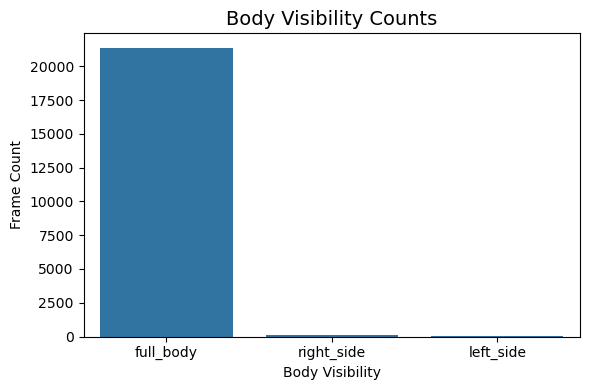

In [26]:
#  Body Visibility 
plt.figure(figsize=(6, 4))
order = df["body_visibility"].value_counts().index
sns.countplot(x="body_visibility", data=df, order=order)
plt.title("Body Visibility Counts", fontsize=14)
plt.xlabel("Body Visibility")
plt.ylabel("Frame Count")
plt.tight_layout()
plt.show()


<h4 style="color:rgb(29, 75, 130);">Knee Angle Distribution</h4>

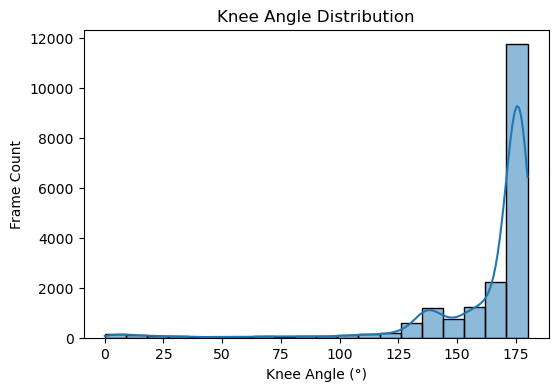

In [20]:
#  Knee Angle Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["knee_angle"].dropna(), bins=20, kde=True)
plt.title("Knee Angle Distribution")
plt.xlabel("Knee Angle (°)")
plt.ylabel("Frame Count")
plt.show()

<h4 style="color:rgb(29, 75, 130);">Posture Percentage</h4>

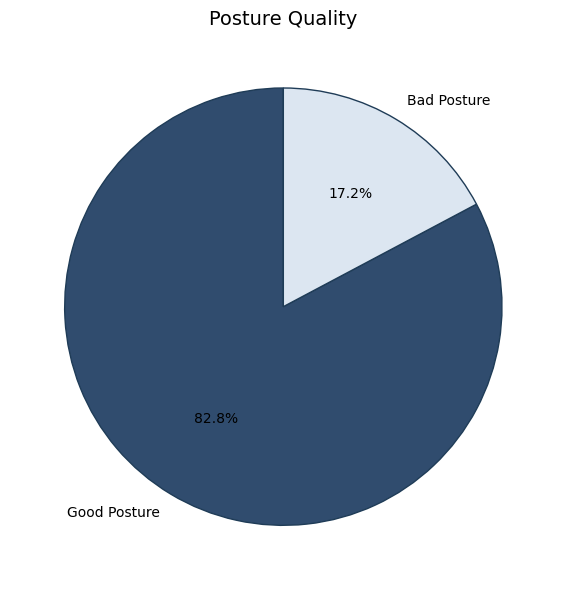

In [27]:
# Posture Percentage
plt.figure(figsize=(8, 6))
df['sitting_posture'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#304C6E', '#DCE6F1', '#7293B5'], startangle=90, wedgeprops={'edgecolor': '#1F3C57'})
plt.title('Posture Quality', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Repetition Progression Over Time</h4>

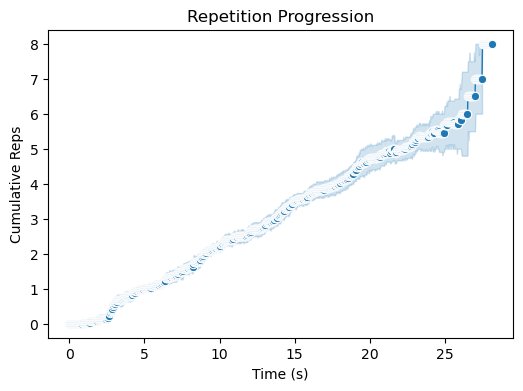

In [21]:
# Repetition Progression Over Time
plt.figure(figsize=(6, 4))
sns.lineplot(x="timestamp", y="rep_count", data=df, marker="o", lw=1)
plt.title("Repetition Progression")
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Reps")
plt.show()

<h4 style="color:rgb(29, 75, 130);">Heel-to-Hip Distance Distribution</h4>

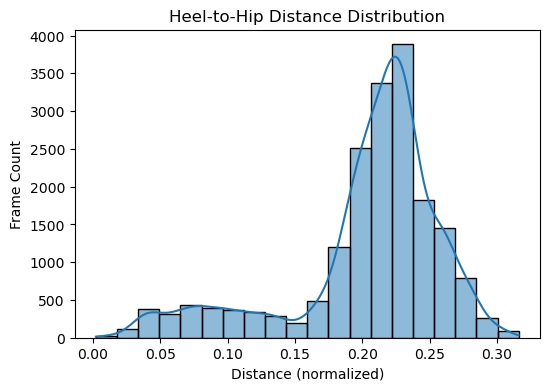

In [22]:
#  Heel‑to‑Hip Distance Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df["distance"].dropna(), bins=20, kde=True)
plt.title("Heel‑to‑Hip Distance Distribution")
plt.xlabel("Distance (normalized)")
plt.ylabel("Frame Count")
plt.show()

<h3 style="color: #0F52BA;">1.3 Data Preprocessing</h3>

<h4 style="color: #2F70C0;">1.3.1 Data Cleaning</h4>

In [29]:
def clean_data(df):
    """
    Cleans the DataFrame for reliable LSTM input and subsequent video-level scoring.
    
    Steps:
      1. Remove frames where body_visibility is "not_visible".
      2. Drop rows with critical missing values in key features: 'knee_angle' and 'distance'.
      3. Remove outlier values in 'knee_angle' (set values < 0 or > 180 to NaN).
      4. Forward-fill missing values.
      5. Reset the index.
    
    Args:
        df (pd.DataFrame): The raw DataFrame extracted from videos.
    
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    
    # ---------------------------------------------------------------------------
    # Remove frames where the body is not visible.
    # ---------------------------------------------------------------------------
    df = df[df["body_visibility"] != "not_visible"].copy()
    
    # ---------------------------------------------------------------------------
    # Drop rows with critical missing values in key features.
    # Here, we only require "knee_angle" and "distance" to be present.
    # ---------------------------------------------------------------------------
    df = df.dropna(subset=["knee_angle", "distance"])
    
    # ---------------------------------------------------------------------------
    #  Remove outliers in "knee_angle".
    #  Set values below 0 or above 180 degrees to NaN.
    # ---------------------------------------------------------------------------
    df.loc[(df["knee_angle"] < 0) | (df["knee_angle"] > 180), "knee_angle"] = np.nan
    
    # ---------------------------------------------------------------------------
    #  Forward-fill missing values to maintain data continuity.
    # ---------------------------------------------------------------------------
    df.ffill(inplace=True)
    
    # ---------------------------------------------------------------------------
    #  Reset the DataFrame index to ensure a continuous, clean index.
    # ---------------------------------------------------------------------------
    df.reset_index(drop=True, inplace=True)
    
    return df

# Display dataset information before and after cleaning.

print("=" * 50)
print("Dataset Details (Before Cleaning):")
df.info()  # Call without print() to avoid extra 'None'
print(f"Data shape before cleaning: {df.shape}\n")

df_clean = clean_data(df)

print("=" * 50)
print("Dataset Details (After Cleaning):")
df_clean.info()
print(f"Data shape after cleaning: {df_clean.shape}\n")


Dataset Details (Before Cleaning):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21522 entries, 0 to 21521
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frame_index        21522 non-null  int64  
 1   timestamp          21522 non-null  float64
 2   body_visibility    21522 non-null  object 
 3   sitting_posture    21522 non-null  object 
 4   leg                21522 non-null  object 
 5   leg_status         21522 non-null  object 
 6   knee_angle         18738 non-null  float64
 7   distance           18738 non-null  float64
 8   rep_count          21522 non-null  int64  
 9   neck_inclination   21522 non-null  int64  
 10  torso_inclination  21522 non-null  int64  
 11  exercise_type      21522 non-null  object 
 12  video_path         21522 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 2.1+ MB
Data shape before cleaning: (21522, 13)

Dataset Details (After Cleaning):

<h4 style="color: #2F70C0;">1.3.3 One-Hot Encode</h4>

In [30]:
# -----------------------------------------------------------------------------
# Function: encode_categorical
# -----------------------------------------------------------------------------
def encode_categorical(df, categorical_cols):
    """
    Applies one-hot encoding to specified categorical columns after filling missing values with the mode.
    
    Args:
        df (pd.DataFrame): The DataFrame to encode.
        categorical_cols (list): List of column names to one-hot encode.
    
    Returns:
        pd.DataFrame: The transformed DataFrame with one-hot encoded columns.
    """
    # Fill missing values in each categorical column with the mode of that column.
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
    
    # Initialize OneHotEncoder with settings for scikit-learn 1.2+.
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    
    # Fit the encoder to the specified categorical columns and transform the data.
    transformed = encoder.fit_transform(df[categorical_cols])
    
    # Generate new column names based on the encoder's categories.
    new_cols = []
    for col, cats in zip(categorical_cols, encoder.categories_):
        new_cols.extend([f"{col}_{cat}" for cat in cats])
    
    # Create a new DataFrame from the transformed data.
    df_ohe = pd.DataFrame(transformed, columns=new_cols, index=df.index)
    
    # Drop the original categorical columns from the DataFrame.
    df = df.drop(columns=categorical_cols)
    # Concatenate the new one-hot encoded columns with the remaining DataFrame.
    df = pd.concat([df, df_ohe], axis=1)
    
    return df

# -----------------------------------------------------------------------------
# Function: main
# -----------------------------------------------------------------------------
def main(df_clean):
    """
    Main function to one-hot encode specific categorical columns after filling missing values.
    
    The function encodes the following columns:
      - body_visibility: Indicates which side is visible ("left_side", "right_side", "not_visible")
      - sitting_posture: Posture status (e.g., "Good Posture", "Bad Posture")
      - leg: Active leg ("Left" or "Right")
      - leg_status: Derived leg state ("Pulled" or "Rest")
    
    Args:
        df_clean (pd.DataFrame): The input DataFrame that has been cleaned.
    
    Returns:
        pd.DataFrame: The DataFrame after applying one-hot encoding.
    """
    
    # Define the categorical columns to encode.
    categorical_cols = ["body_visibility", "sitting_posture", "leg", "leg_status"]
    
    # Apply one-hot encoding to these columns.
    df_encoded = encode_categorical(df_clean, categorical_cols=categorical_cols)
    
    print(f"After one-hot encoding: {df_encoded.shape}")
    return df_encoded

# -----------------------------------------------------------------------------
# Step: Load the Cleaned Data and Process It
# -----------------------------------------------------------------------------

df_final = main(df_clean)

# -----------------------------------------------------------------------------
# Save the Final Cleaned Data (After One-Hot Encoding)
# -----------------------------------------------------------------------------
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_path = os.path.join(output_folder, "final_cleaned_data_chair.csv")
pkl_path = os.path.join(output_folder, "final_cleaned_data_chair.pkl")

# Save the DataFrame in CSV format (without including the index).
df_final.to_csv(csv_path, index=False)
# Save the DataFrame as a pickle file.
df_final.to_pickle(pkl_path)

print(f"Final cleaned data saved to {csv_path} and {pkl_path}")


After one-hot encoding: (18738, 18)
Final cleaned data saved to output/final_cleaned_data_chair.csv and output/final_cleaned_data_chair.pkl


<h3 style="color: #0F52BA;">1.4 Dataset Information (After Preprocessing)</h3>

<h4 style="color: #2F70C0;">1.4.1 Dataset Details</h4>

In [31]:
# -----------------------------------------------------------------------------
# 1. Load the Final Cleaned & One-Hot Encoded Data
# -----------------------------------------------------------------------------
df_clean = pd.read_pickle("output/final_cleaned_data_chair.pkl")

In [36]:
print("=" * 50)
print("Dataset Details (After Preprocessing):")
print(f"• Number of videos: {df_clean['video_path'].nunique()} videos")
print(f"• Total frames: {len(df_clean):,} frames")

# Calculate total repetitions as the sum of each video's max rep_count
total_reps = df_clean.groupby("video_path")["rep_count"].max().sum()
print(f"• Total repetitions: {int(total_reps)} reps")

print(f"• Time range: {df_clean['timestamp'].min():.1f}s to {df_clean['timestamp'].max():.1f}s")
print(f"• Average FPS: {len(df_clean) / df_clean['timestamp'].max():.1f}")

Dataset Details (After Preprocessing):
• Number of videos: 30 videos
• Total frames: 18,738 frames
• Total repetitions: 162 reps
• Time range: 0.9s to 28.1s
• Average FPS: 666.0


<h4 style="color: #2F70C0;">1.4.2 Dataset Columns</h4>

In [63]:

# ----------------------------
# Define descriptive column metadata
# ----------------------------
columns_details = {
    "frame_index": "Frame sequence number",
    "timestamp": "Time elapsed (seconds) from start of video",
    "knee_angle": "Knee angle in degrees",
    "distance": "Normalized heel‑to‑hip distance",
    "rep_count": "Repetition count for active side",
    "neck_inclination": "Neck inclination angle (degrees)",
    "torso_inclination": "Torso inclination angle (degrees)",
    "exercise_type": "Exercise type (e.g., 'Heel Exercise')",
    "video_path": "Video file name",
    "body_visibility_left_side": "One‑hot: left side visible (1/0)",
    "body_visibility_full_body": "One‑hot: full body (1/0)",
    "body_visibility_right_side": "One‑hot: right side visible (1/0)",
    "sitting_posture_Bad Posture": "One‑hot: bad posture (1/0)",
    "sitting_posture_Good Posture": "One‑hot: good posture (1/0)",
    "leg_Left": "One‑hot: active leg 'Left' (1/0)",
    "leg_Right": "One‑hot: active leg 'Right' (1/0)",
    "leg_status_Extended": "One‑hot: leg state 'Pulled' (1/0)",
    "leg_status_Rest": "One‑hot: leg state 'Rest' (1/0)"
}

# ----------------------------
# Print each column with its description
# ----------------------------
print("\n" + "=" * 50)
print("Dataset Columns:")
for col, desc in columns_details.items():
    print(f"- {col:<30}: {desc}")

# ----------------------------
# Show a sample of the DataFrame
# ----------------------------
print("\nDataFrame Head:")
print(df_clean.head(5))



Dataset Columns:
- frame_index                   : Frame sequence number
- timestamp                     : Time elapsed (seconds) from start of video
- knee_angle                    : Knee angle in degrees
- distance                      : Normalized heel‑to‑hip distance
- rep_count                     : Repetition count for active side
- neck_inclination              : Neck inclination angle (degrees)
- torso_inclination             : Torso inclination angle (degrees)
- exercise_type                 : Exercise type (e.g., 'Heel Exercise')
- video_path                    : Video file name
- body_visibility_left_side     : One‑hot: left side visible (1/0)
- body_visibility_full_body     : One‑hot: full body (1/0)
- body_visibility_right_side    : One‑hot: right side visible (1/0)
- sitting_posture_Bad Posture   : One‑hot: bad posture (1/0)
- sitting_posture_Good Posture  : One‑hot: good posture (1/0)
- leg_Left                      : One‑hot: active leg 'Left' (1/0)
- leg_Right        

<h4 style="color: #2F70C0;">1.4.3 Dataset Visualization (After Preprocessing)</h4>

<h4 style="color:rgb(29, 75, 130);">Body Visibility Distribution</h4>

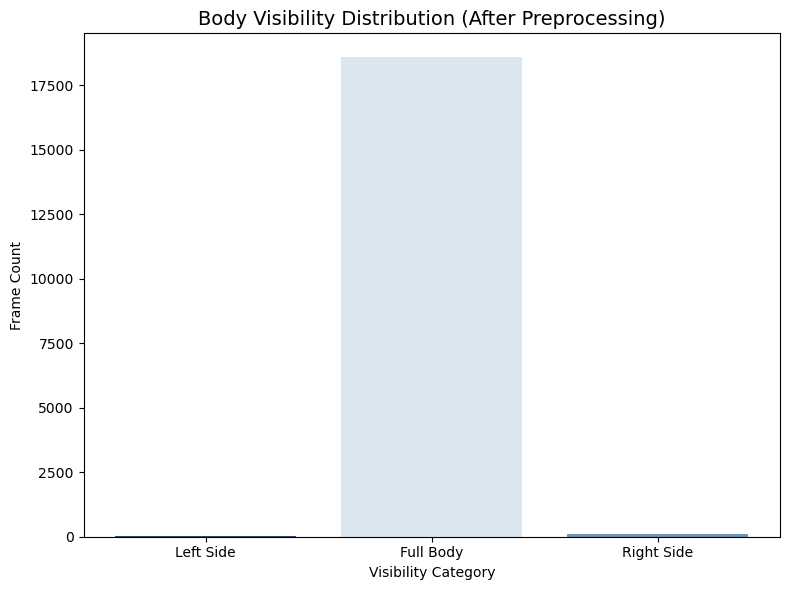

In [40]:
# Sum the one‑hot encoded visibility columns to get frame counts
visibility_counts = {
    "Left Side": df_clean["body_visibility_left_side"].sum(),
    "Full Body": df_clean["body_visibility_full_body"].sum(),
    "Right Side": df_clean["body_visibility_right_side"].sum()
}

plt.figure(figsize=(8, 6))
plt.bar(visibility_counts.keys(), visibility_counts.values(), 
        color=['#304C6E', '#DCE6F1', '#7293B5'])
plt.title("Body Visibility Distribution (After Preprocessing)", fontsize=14)
plt.xlabel("Visibility Category")
plt.ylabel("Frame Count")
plt.tight_layout()
plt.show()


<h4 style="color:rgb(29, 75, 130);">Knee Angle Distribution</h4>

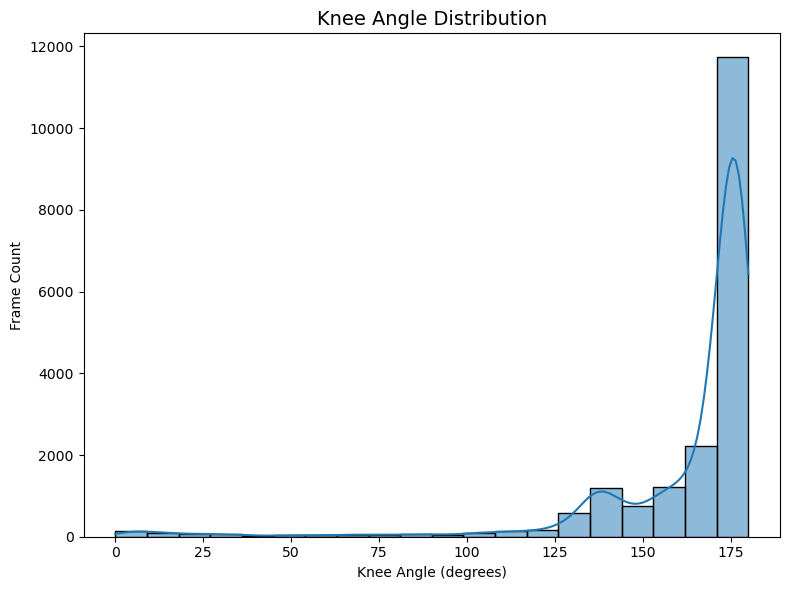

In [41]:
# Plot a histogram with KDE for the knee_angle column
plt.figure(figsize=(8, 6))
sns.histplot(df_clean["knee_angle"].dropna(), bins=20, kde=True)
plt.title("Knee Angle Distribution", fontsize=14)
plt.xlabel("Knee Angle (degrees)")
plt.ylabel("Frame Count")
plt.tight_layout()
plt.show()


<h4 style="color:rgb(29, 75, 130);">Posture Percentage</h4>

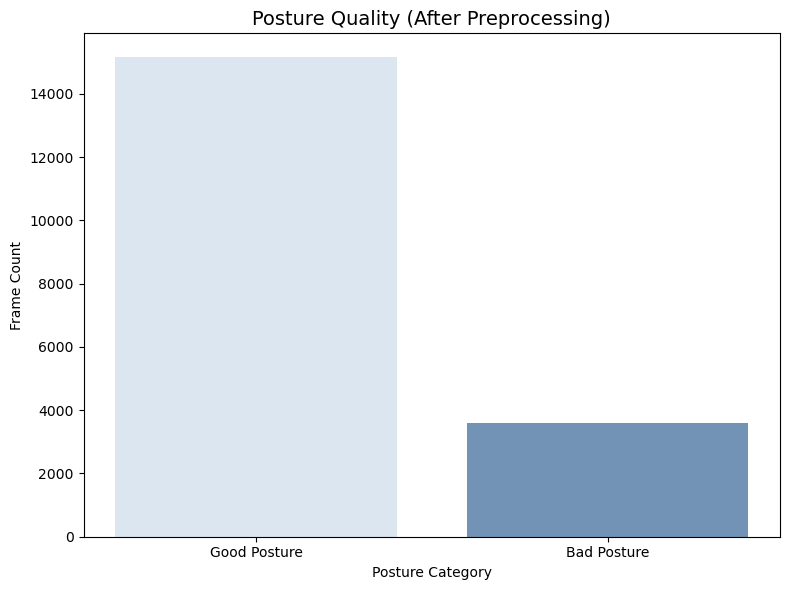

In [43]:
# Sum the one‑hot posture columns to get counts
posture_counts = {
    "Good Posture": df_clean["sitting_posture_Good Posture"].sum(),
    "Bad Posture": df_clean["sitting_posture_Bad Posture"].sum()
}

plt.figure(figsize=(8, 6))
plt.bar(posture_counts.keys(), posture_counts.values(), color=['#DCE6F1', '#7293B5'])
plt.title("Posture Quality (After Preprocessing)", fontsize=14)
plt.xlabel("Posture Category")
plt.ylabel("Frame Count")
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Repetition Progression Over Time</h4>

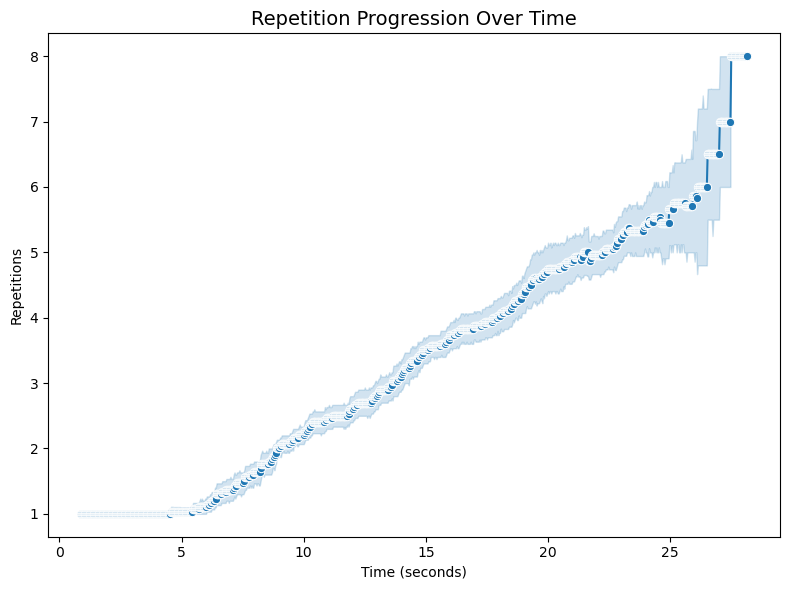

In [44]:
# Line plot of cumulative rep_count versus timestamp
plt.figure(figsize=(8, 6))
sns.lineplot(x="timestamp", y="rep_count", data=df_clean, marker="o")
plt.title("Repetition Progression Over Time", fontsize=14)
plt.xlabel("Time (seconds)")
plt.ylabel("Repetitions")
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Heel-to-Hip Distance Distribution</h4>

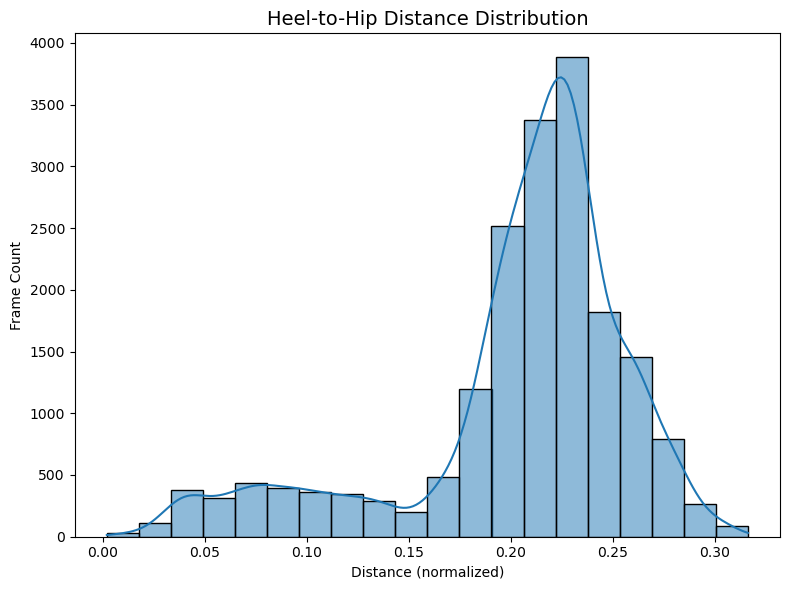

In [45]:
# Histogram with KDE for the distance column
plt.figure(figsize=(8, 6))
sns.histplot(df_clean["distance"].dropna(), bins=20, kde=True)
plt.title("Heel-to-Hip Distance Distribution", fontsize=14)
plt.xlabel("Distance (normalized)")
plt.ylabel("Frame Count")
plt.tight_layout()
plt.show()

<h3 style="color: #0F52BA;">1.5 Reshaping for LSTM Input</h3>

In [64]:
# Load the DataFrame which contains all frame‑level features, one‑hot columns, and video_path.
df_clean = pd.read_pickle("output/final_cleaned_data_chair.pkl")
print("Loaded cleaned & one‑hot encoded data. Shape:", df_clean.shape)

Loaded cleaned & one‑hot encoded data. Shape: (18738, 18)


<h4 style="color: #2F70C0;">1.5.1 Compute Ideal Values and Video-Level Performance Scores</h4>

<h5>Step 1: Deriving Ideal Values</h5>
<p>
  First, we compute the ideal (benchmark) values for our key metrics by separating the data into two phases:
  <strong>Extended</strong> and <strong>Rest</strong>.
</p>
<ul>
  <li>
    <strong>Ideal Knee Angle (Extended):</strong> The average knee angle across all frames where the leg is in the "Extended" state.
  </li>
  <li>
    <strong>Ideal Knee Angle (Rest):</strong> The average knee angle across all frames where the leg is in the "Rest" state.
  </li>
  <li>
    <strong>Ideal Distance (Extended):</strong> The average normalized heel-to-hip distance for frames in the "Extended" state.
  </li>
  <li>
    <strong>Ideal Distance (Rest):</strong> The average normalized heel-to-hip distance for frames in the "Rest" state.
  </li>
</ul>
<p>
  These averages serve as our benchmarks for what is considered optimal in each phase.
</p>

<h5>Step 2: Computing Phase-Specific Errors</h5>
<p>
  For each video, we then compute the average values for both the knee angle and the heel-to-hip distance separately for the "Extended" and "Rest" phases.
  Next, we calculate the absolute error for each metric as follows:
</p>
<ul>
  <li>
    <strong>Error in Knee Angle (Extended):</strong> |Observed Extended Knee Angle − Ideal Extended Knee Angle|
  </li>
  <li>
    <strong>Error in Knee Angle (Rest):</strong> |Observed Rest Knee Angle − Ideal Rest Knee Angle|
  </li>
  <li>
    <strong>Error in Distance (Extended):</strong> |Observed Extended Distance − Ideal Extended Distance|
  </li>
  <li>
    <strong>Error in Distance (Rest):</strong> |Observed Rest Distance − Ideal Rest Distance|
  </li>
</ul>
<p>
  We then compute the average error for each type (knee angle and distance) by averaging the errors obtained for the "Extended" and "Rest" phases.
</p>

<h5>Step 3: Combining Errors and Mapping to a Performance Score</h5>
<p>
  Next, we combine the errors from the knee angle and the distance using weighted averaging:
</p>
<p>
  <strong>Combined Error (E):</strong> <br>
  E = (w<sub>knee</sub> × avg_error<sub>knee</sub>) + (w<sub>distance</sub> × avg_error<sub>distance</sub>)
  <br><br>
  where:   
  <ul>
    <li>w<sub>knee</sub> is the weight for the knee angle error.</li>
    <li>w<sub>distance</sub> is the weight for the distance error.</li>
  </ul>
</p>
<p>
  Finally, we map this combined error to a performance score on a scale of 0 to 100 using a linear equation:
</p>
<p>
  <strong>Performance Score:</strong> <br>
  Score = 100 × (1 − (E / E<sub>max</sub>))
  <br>
  where E<sub>max</sub> is the maximum error threshold (any error equal to or exceeding E<sub>max</sub> will yield a score of 0). The resulting score is then clamped between 0 and 100.
</p>

<h5>Overall Process</h5>
<p>
  In summary, we transform the raw continuous measurements (knee angle and heel-to-hip distance) into a performance score using the following procedure:
</p>
<ol>
  <li>
    <strong>Derive Ideal Values:</strong> Calculate the ideal (benchmark) averages for knee angle and distance in both "Extended" and "Rest" phases.
  </li>
  <li>
    <strong>Compute Errors:</strong> For each video, determine the deviation (absolute error) of the observed averages from the ideal values.
  </li>
  <li>
    <strong>Combine Errors:</strong> Use a weighted average of the errors to obtain a combined error.
  </li>
  <li>
    <strong>Map to a Score:</strong> Convert the combined error to a performance score on a 0–100 scale, where a lower error results in a higher score.
  </li>
</ol>
<p>
  This process provides an outcome (performance score) that reflects how closely the exercise performed in each video adheres to the ideal benchmarks.
</p>


In [65]:
# 1. Compute global ideal values
extended_frames = df_clean[df_clean["leg_status_Extended"] == 1]
rest_frames     = df_clean[df_clean["leg_status_Rest"] == 1]

ideal_knee_ext   = extended_frames["knee_angle"].mean()
ideal_knee_rest  = rest_frames["knee_angle"].mean()
ideal_dist_ext   = extended_frames["distance"].mean()
ideal_dist_rest  = rest_frames["distance"].mean()

print("Global Ideal Values:")
print(f"  Knee Angle (Extended): {ideal_knee_ext:.2f}°")
print(f"  Knee Angle (Rest):      {ideal_knee_rest:.2f}°")
print(f"  Distance (Extended):   {ideal_dist_ext:.4f}")
print(f"  Distance (Rest):       {ideal_dist_rest:.4f}")

# 2. Helper: performance score function
def compute_score(group, kip_ext, kip_rest, dist_ext, dist_rest,
                  w_knee=0.7, w_dist=0.3, E_max=20):
    """Compare group’s mean metrics to global ideals and return 0–100 score."""
    # observed
    obs_knee_ext  = group[group["leg_status_Extended"] == 1]["knee_angle"].mean()
    obs_knee_rest = group[group["leg_status_Rest"] == 1]["knee_angle"].mean()
    obs_dist_ext  = group[group["leg_status_Extended"] == 1]["distance"].mean()
    obs_dist_rest = group[group["leg_status_Rest"] == 1]["distance"].mean()
    # fallback to ideal if no frames
    obs_knee_ext  = obs_knee_ext  if not np.isnan(obs_knee_ext)  else kip_ext
    obs_knee_rest = obs_knee_rest if not np.isnan(obs_knee_rest) else kip_rest
    obs_dist_ext  = obs_dist_ext  if not np.isnan(obs_dist_ext)  else dist_ext
    obs_dist_rest = obs_dist_rest if not np.isnan(obs_dist_rest) else dist_rest
    # errors
    err_knee_ext  = abs(obs_knee_ext  - kip_ext)
    err_knee_rest = abs(obs_knee_rest - kip_rest)
    err_dist_ext  = abs(obs_dist_ext  - dist_ext)
    err_dist_rest = abs(obs_dist_rest - dist_rest)
    # average
    avg_err_knee = (err_knee_ext + err_knee_rest) / 2
    avg_err_dist = (err_dist_ext + err_dist_rest) / 2
    # combined and map to score
    combined = w_knee * avg_err_knee + w_dist * avg_err_dist
    score = 100 * (1 - combined / E_max)
    return max(0, min(100, score))

# 3. Compute per‑video scores
performance_scores = {}
for video, grp in df_clean.groupby("video_path"):
    performance_scores[video] = compute_score(
        grp, ideal_knee_ext, ideal_knee_rest, ideal_dist_ext, ideal_dist_rest
    )

# Display results
print("\nPerformance Scores per Video:")
for vid, sc in performance_scores.items():
    print(f"  {vid:<25}: {sc:.1f}")

Global Ideal Values:
  Knee Angle (Extended): 150.84°
  Knee Angle (Rest):      168.44°
  Distance (Extended):   0.1392
  Distance (Rest):       0.2335

Performance Scores per Video:
  Ac1_Eg7_R1_C.avi         : 82.2
  Ac1_Eg7_R2_C.avi         : 54.2
  Ac1_Eg7_R3_C.avi         : 82.9
  Ac1_Eg7_R4_C.avi         : 62.7
  Ac1_Eg7_R5_C.avi         : 0.0
  Ac1_Eg7_R6_C.avi         : 0.0
  Ac2_Eg7_R1_C.avi         : 79.6
  Ac2_Eg7_R2_C.avi         : 81.4
  Ac2_Eg7_R3_C.avi         : 13.5
  Ac2_Eg7_R4_C.avi         : 0.0
  Ac2_Eg7_R5_C.avi         : 47.1
  Ac2_Eg7_R6_C.avi         : 55.1
  Ac3_Eg7_R1_C.avi         : 45.6
  Ac3_Eg7_R2_C.avi         : 72.6
  Ac3_Eg7_R3_C.avi         : 75.2
  Ac3_Eg7_R4_C.avi         : 39.4
  Ac3_Eg7_R5_C.avi         : 39.7
  Ac3_Eg7_R6_C.avi         : 42.3
  Ac4_Eg7_R1_C.avi         : 87.5
  Ac4_Eg7_R2_C.avi         : 52.9
  Ac4_Eg7_R3_C.avi         : 71.0
  Ac4_Eg7_R4_C.avi         : 86.8
  Ac4_Eg7_R5_C.avi         : 84.9
  Ac4_Eg7_R6_C.avi         : 45.2
  Ac

<h4 style="color: #2F70C0;">1.5.2 Reshaping the Data for LSTM Input</h4>

In [66]:
def prepare_sequences_for_lstm(df, seq_len=700):
    """Return X of shape (n_videos, seq_len, n_features) and list of video IDs."""
    exclude = {"frame_index", "timestamp", "video_path", "exercise_type"}
    feature_cols = [c for c in df.columns if c not in exclude]
    sequences, vids = [], []
    
    for vid, grp in df.groupby("video_path"):
        arr = grp.sort_values("frame_index")[feature_cols].to_numpy()
        # pad or trim
        if arr.shape[0] < seq_len:
            pad = np.zeros((seq_len - arr.shape[0], arr.shape[1]))
            arr = np.vstack([arr, pad])
        else:
            arr = arr[:seq_len, :]
        sequences.append(arr)
        vids.append(vid)
    
    return np.stack(sequences), vids

X, video_ids = prepare_sequences_for_lstm(df_clean, seq_len=700)
print("LSTM input X shape:", X.shape)
print("Number of sequences:", len(video_ids))

LSTM input X shape: (30, 700, 14)
Number of sequences: 30


<h4 style="color: #2F70C0;">1.5.3 Normalization and Target Vector Creation</h4>

In [68]:
from sklearn.preprocessing import StandardScaler

# 1. Normalize
n_samples, seq_len, n_feats = X.shape
flat = X.reshape(-1, n_feats)
scaler = StandardScaler()
flat_scaled = scaler.fit_transform(flat)
X_normalized = flat_scaled.reshape(n_samples, seq_len, n_feats)
print("X_normalized shape:", X_normalized.shape)

# 2. Target vector
y = np.array([performance_scores[vid] for vid in video_ids])
print("Target vector y shape:", y.shape)

# -----------------------------------------------------------------------------
# Save the Prepared LSTM Input Data and Video Identifiers
# -----------------------------------------------------------------------------
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)

lstm_sequences_path = os.path.join(output_folder, "lstm_sequences_chair.pkl")
with open(lstm_sequences_path, "wb") as f:
    pkl.dump((X_normalized, video_ids), f)
print("LSTM input data saved to:", lstm_sequences_path)

X_normalized shape: (30, 700, 14)
Target vector y shape: (30,)
LSTM input data saved to: output/lstm_sequences_chair.pkl


<h3 style="color: #0F52BA;">1.6 Data Visualization (Before vs After)</h3> 

Raw data loaded. Shape: (21522, 13)
Cleaned data loaded. Shape: (18738, 18)
LSTM sequences (normalized) loaded. Shape: (30, 700, 14)
Number of video sequences: 30


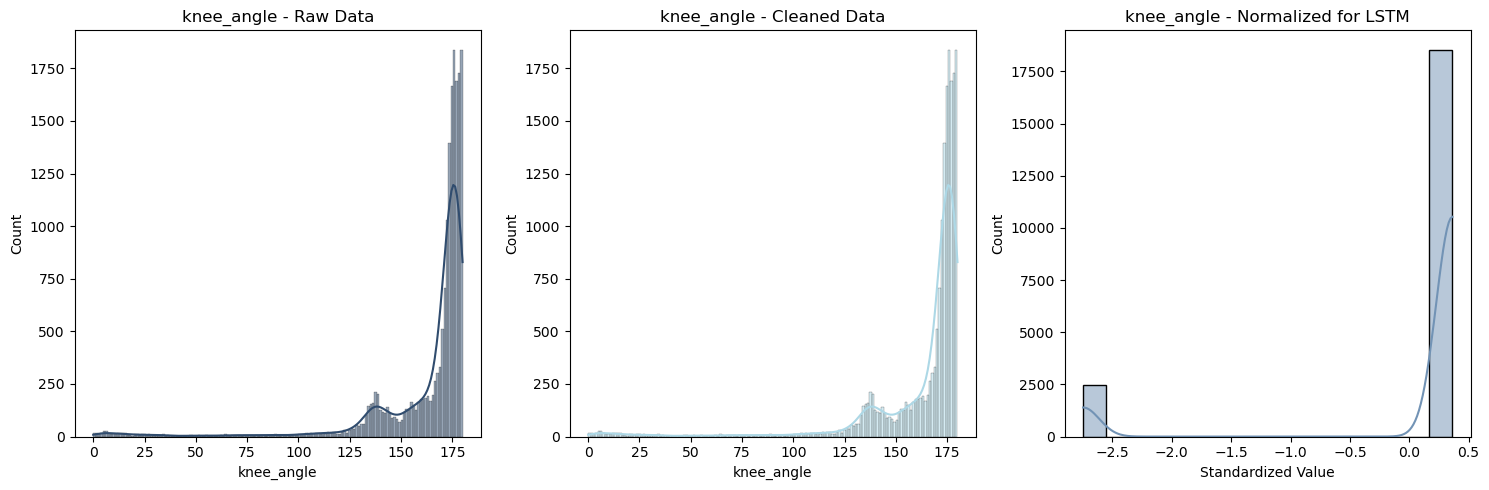

In [70]:
# -----------------------------------------------------------------------------
#  Load the Three Data Sources
# -----------------------------------------------------------------------------
# Adjust these paths to match your actual files.

raw_path = "output/chair_exercise_data.pkl"       
cleaned_path = "output/final_cleaned_data_chair.pkl"  
reshaped_path = "output/lstm_sequences_chair.pkl"      

# Load the raw data 
raw_df = pd.read_pickle(raw_path)
print("Raw data loaded. Shape:", raw_df.shape)

# Load the cleaned data.
cleaned_df = pd.read_pickle(cleaned_path)
print("Cleaned data loaded. Shape:", cleaned_df.shape)

# Load the normalized LSTM sequences (3D array) and video IDs.
with open(reshaped_path, "rb") as f:
    X_normalized, video_ids = pkl.load(f)
print("LSTM sequences (normalized) loaded. Shape:", X_normalized.shape)
print("Number of video sequences:", len(video_ids))

# -----------------------------------------------------------------------------
#  Flatten the Normalized LSTM Data for Visualization
# -----------------------------------------------------------------------------
# X_normalized is a 3D array of shape (num_videos, sequence_length, num_features).
# Flatten to 2D to treat it like a DataFrame for quick histogram plotting.

num_videos, seq_len, num_features = X_normalized.shape
X_flat = X_normalized.reshape(-1, num_features)

normalized_df = pd.DataFrame(X_flat)


# -----------------------------------------------------------------------------
#  Plot the Distribution of 'knee_angle' Across All Three Stages
# -----------------------------------------------------------------------------
feature = "knee_angle"  # Name of the column in raw_df and cleaned_df

# Safety check: ensure the feature is in raw_df and cleaned_df
if feature not in raw_df.columns:
    raise ValueError(f"'{feature}' is not in raw_df columns.")
if feature not in cleaned_df.columns:
    raise ValueError(f"'{feature}' is not in cleaned_df columns.")

plt.figure(figsize=(15, 5))

# Subplot 1: Raw Data
plt.subplot(1, 3, 1)
sns.histplot(raw_df[feature].dropna(), kde=True, color="#304C6E")
plt.title(f"{feature} - Raw Data", fontsize=12)
plt.xlabel(feature)
plt.ylabel("Count")

# Subplot 2: Cleaned Data
plt.subplot(1, 3, 2)
sns.histplot(cleaned_df[feature].dropna(), kde=True, color="lightblue")
plt.title(f"{feature} - Cleaned Data", fontsize=12)
plt.xlabel(feature)
plt.ylabel("Count")

# Subplot 3: Normalized Data 
plt.subplot(1, 3, 3)
sns.histplot(normalized_df.iloc[:, 5], kde=True, color="#7293B5")
plt.title(f"{feature} - Normalized for LSTM", fontsize=12)
plt.xlabel("Standardized Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


<h1 style="color: #002B5B;">2. LSTM Model Building, Training & Evaluation</h1>

<h3 style="color: #0F52BA;">2.1 LSTM Model Architecture</h3> 

In [71]:
# Load the prepared LSTM input data
with open("output/lstm_sequences_chair.pkl", "rb") as f:
    X_normalized, video_ids = pkl.load(f)

# Determine input shape for the model (sequence_length, num_features)
_, sequence_length, num_features = X_normalized.shape
input_shape = (sequence_length, num_features)
print("LSTM input shape:", input_shape)

def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model for regression.
    - LSTM(64) to capture temporal patterns
    - Dropout for regularization
    - Dense layers to map to single output
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Regression output
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model

LSTM input shape: (700, 14)


<h3 style="color: #0F52BA;">2.2 Model Training</h3> 

In [74]:
# -----------------------------------------------------------------------------
# k-Fold Cross Validation Setup and Training
# -----------------------------------------------------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1

val_losses = []
val_maes = []
train_losses = []
train_maes = []

batch_size = 4
epochs = 50

for train_idx, val_idx in kf.split(X_normalized):
    print(f"\nTraining Fold {fold}")
    X_train, X_val = X_normalized[train_idx], X_normalized[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stopping])
    
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold} Evaluation: Validation Loss = {eval_results[0]:.4f}, Validation MAE = {eval_results[1]:.4f}")
    val_losses.append(eval_results[0])
    val_maes.append(eval_results[1])
    
    final_train_loss = history.history["loss"][-1]
    final_train_mae = history.history["mae"][-1]
    print(f"Fold {fold} Final Training Metrics: Loss = {final_train_loss:.4f}, MAE = {final_train_mae:.4f}")
    train_losses.append(final_train_loss)
    train_maes.append(final_train_mae)
    
    fold += 1

avg_val_loss = np.mean(val_losses)
avg_val_mae = np.mean(val_maes)
avg_train_loss = np.mean(train_losses)
avg_train_mae = np.mean(train_maes)
print("\nAverage Validation Loss across folds:", avg_val_loss)
print("Average Validation MAE across folds:", avg_val_mae)
print("Average Training Loss across folds:", avg_train_loss)
print("Average Training MAE across folds:", avg_train_mae)


Training Fold 1
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 4108.4536 - mae: 59.3517 - val_loss: 1383.6405 - val_mae: 32.0305
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 3594.9185 - mae: 53.1692 - val_loss: 1325.6768 - val_mae: 31.3856
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 3534.3704 - mae: 54.7180 - val_loss: 1262.0139 - val_mae: 30.6468
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 3197.1479 - mae: 50.7626 - val_loss: 1189.6090 - val_mae: 29.7638
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 3068.6228 - mae: 50.8006 - val_loss: 1109.7562 - val_mae: 28.7340
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 2894.0791 - mae: 48.7111 - val_loss: 1027.9120 - val_mae: 27.6126
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 2571.3911 - mae: 44.0230 - val_loss: 944.2153 - val_mae: 26.3863
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 2434.1831 - mae: 43.2686 - val_loss: 862.9404 - val_mae: 2

<h3 style="color: #0F52BA;">2.3 Evaluation Metrics</h3> 

In [75]:
print("\n=== Cross-Validation Results ===")
print(f"Average Training Loss:      {np.mean(train_losses):.4f}")
print(f"Average Training MAE:       {np.mean(train_maes):.4f}")
print(f"Average Validation Loss:    {np.mean(val_losses):.4f}")
print(f"Average Validation MAE:     {np.mean(val_maes):.4f}")


=== Cross-Validation Results ===
Average Training Loss:      603.2340
Average Training MAE:       19.0597
Average Validation Loss:    645.9650
Average Validation MAE:     19.6571


In [77]:
# save the model
model_save_path = "output/final_chair_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to output/final_chair_model.h5


<h3 style="color: #0F52BA;">2.4 Predicted vs Actual Accuracy</h3> 

Model loaded from output/final_chair_model.h5 and recompiled successfully.
LSTM sequences (normalized) loaded. Shape: (30, 700, 14)
Number of video sequences: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
Predictions shape: (30,)
Target vector (y) shape: (30,)


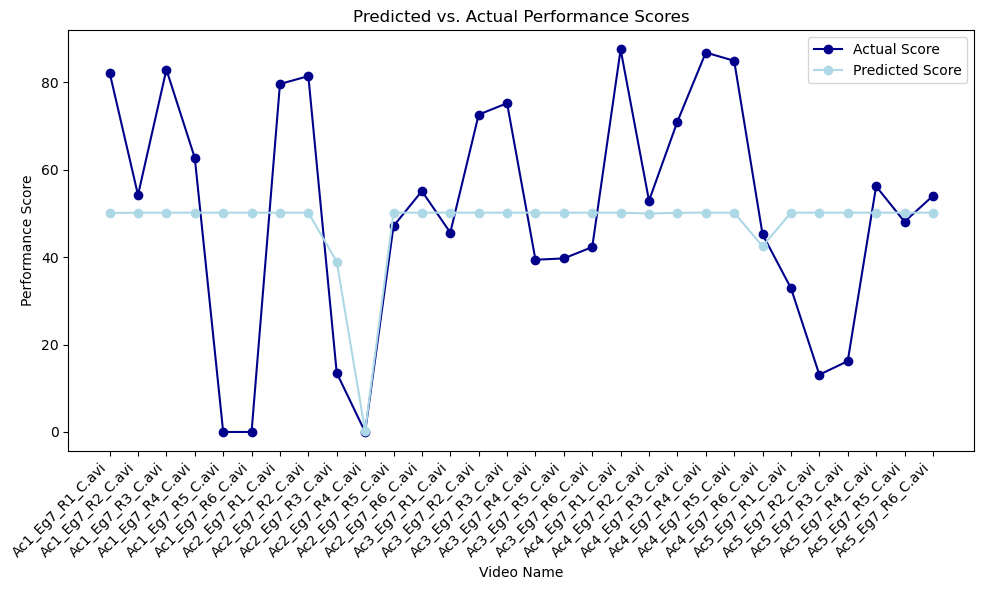

In [78]:
# -----------------------------------------------------------------------------
#  Load the Saved Model
# -----------------------------------------------------------------------------
model_save_path = "output/final_chair_model.h5"  # Adjust this path if needed.
loaded_model = load_model(model_save_path, compile=False)
loaded_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(f"Model loaded from {model_save_path} and recompiled successfully.")

# -----------------------------------------------------------------------------
#  Load the Prepared LSTM Input Data
# -----------------------------------------------------------------------------
lstm_sequences_path = "output/lstm_sequences_chair.pkl"
with open(lstm_sequences_path, "rb") as f:
    X_normalized, video_ids = pkl.load(f)
print("LSTM sequences (normalized) loaded. Shape:", X_normalized.shape)
print("Number of video sequences:", len(video_ids))

# -----------------------------------------------------------------------------
#  Define the Performance Scores Dictionary
# -----------------------------------------------------------------------------
video_scores = {
    "Ac1_Eg7_R1_C.avi": 82.2,  "Ac1_Eg7_R2_C.avi": 54.2,  "Ac1_Eg7_R3_C.avi": 82.9,
    "Ac1_Eg7_R4_C.avi": 62.7,  "Ac1_Eg7_R5_C.avi":  0.0,  "Ac1_Eg7_R6_C.avi":  0.0,
    "Ac2_Eg7_R1_C.avi": 79.6,  "Ac2_Eg7_R2_C.avi": 81.4,  "Ac2_Eg7_R3_C.avi": 13.5,
    "Ac2_Eg7_R4_C.avi":  0.0,  "Ac2_Eg7_R5_C.avi": 47.1,  "Ac2_Eg7_R6_C.avi": 55.1,
    "Ac3_Eg7_R1_C.avi": 45.6,  "Ac3_Eg7_R2_C.avi": 72.6,  "Ac3_Eg7_R3_C.avi": 75.2,
    "Ac3_Eg7_R4_C.avi": 39.4,  "Ac3_Eg7_R5_C.avi": 39.7,  "Ac3_Eg7_R6_C.avi": 42.3,
    "Ac4_Eg7_R1_C.avi": 87.5,  "Ac4_Eg7_R2_C.avi": 52.9,  "Ac4_Eg7_R3_C.avi": 71.0,
    "Ac4_Eg7_R4_C.avi": 86.8,  "Ac4_Eg7_R5_C.avi": 84.9,  "Ac4_Eg7_R6_C.avi": 45.2,
    "Ac5_Eg7_R1_C.avi": 32.9,  "Ac5_Eg7_R2_C.avi": 13.1,  "Ac5_Eg7_R3_C.avi": 16.2,
    "Ac5_Eg7_R4_C.avi": 56.2,  "Ac5_Eg7_R5_C.avi": 48.1,  "Ac5_Eg7_R6_C.avi": 54.0
}
# -----------------------------------------------------------------------------
#  Generate Predictions Using the Loaded Model
# -----------------------------------------------------------------------------
predictions = loaded_model.predict(X_normalized).flatten()  # Flatten to a 1D array
print("Predictions shape:", predictions.shape)

# -----------------------------------------------------------------------------
#  Construct the Target Vector (y) from the Performance Scores
# -----------------------------------------------------------------------------
# The target vector 'y' is created by mapping each video (using its basename from video_ids)
# to its corresponding performance score from the video_scores dictionary.
y_true = np.array([video_scores.get(os.path.basename(video), 0) for video in video_ids])
print("Target vector (y) shape:", y_true.shape)

# -----------------------------------------------------------------------------
#  Visualization - Predicted vs. Actual Performance Scores
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot actual performance scores (green line with circle markers).
plt.plot(range(len(video_ids)), y_true, 'o-', color='darkblue', label="Actual Score")
# Plot predicted performance scores (red line with circle markers).
plt.plot(range(len(video_ids)), predictions, 'o-', color='lightblue', label="Predicted Score")

# Set x-axis tick labels to the video file names (basenames).
plt.xticks(range(len(video_ids)), [os.path.basename(video) for video in video_ids], rotation=45, ha='right')

plt.xlabel("Video Name")
plt.ylabel("Performance Score")
plt.title("Predicted vs. Actual Performance Scores")
plt.legend()
plt.tight_layout()
plt.show()
